# Livrable 1 : Classification Binaire
|Erwan Martin|Thibaut Liger-Hellard|Arnaud Maturel|Guillaume Le Cocguen|Victorien Goudeau|
|------------|---------------------|--------------|--------------------|-----------------|

# **Contexte**:
L'entreprise TouNum, spécialisée dans la numérisation de documents, collabore avec des spécialistes en Data Science de CESI pour développer une solution de Machine Learning capable de générer automatiquement des légendes pour les images numérisées. Ce projet vise à enrichir leur offre de services en répondant aux besoins de clients ayant d'importantes quantités de données à classer. Le défi inclut le nettoyage des images de qualité variable et la distinction entre photos et autres types d'images avant l'analyse. L'approche utilisera des technologies avancées telles que les réseaux de neurones convolutifs (CNN) et récurrents (RNN), en s'appuyant sur Python et des librairies spécialisées. Un prototype est attendu dans cinq semaines, suivi d'une présentation détaillée et d'une discussion sur l'intégration et la maintenance de la solution.

# **Objectif**:

L'objectif de ce projet est de développer un modèle de classification binaire capable de distinguer les images de photos des autres types d'images. Le modèle sera entraîné sur un jeu de données étiqueté et évalué sur un jeu de données de test distinct. Les performances du modèle seront mesurées en termes de précision, de rappel et de F1-score. Le modèle final sera évalué sur un ensemble de données non étiqueté pour tester sa capacité à généraliser à de nouvelles images.

# **Données**:

Notre jeu de données contient plusieurs milliers d'images de différentes tailles et qualités. Ces images ne sont pas étiquetées, mais les images étant bien archivées, nous allons pouvoir les étiquetter manuellement.

# **Défis techniques**:

- Étiquettage des données: Les images ne sont pas étiquetées, il faudra donc le faire manuellement pour entraîner le modèle.

- Qualité des images: Les images sont de qualité variable, ce qui peut affecter les performances du modèle.

- Modèle de classification: Le modèle doit être capable de distinguer les images de photos des autres types d'images avec une précision élevée. Il faudra peut-être expérimenter avec différents types de modèles pour obtenir les meilleures performances.

- Évaluation du modèle: Le modèle sera évalué sur un ensemble de données de test distinct pour mesurer sa précision, son rappel et son F1-score. Il sera également évalué sur un ensemble de données non étiqueté pour tester sa capacité à généraliser à de nouvelles images.


# **Preprocessing**

Afin de répondre au besoin de la société TouNum, nous allons dans un premier temps traiter les images, c'est à dire avoir une phase de `preprocessing` pour les rendre exploitables par notre modèle. Nous utiliserons de nombreuses bibliothèques python comme `tensorflow`, `scikit-learn` et `pandas`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import sklearn
import sklearn.model_selection
import tensorflow as tf
import tensorboard

from datetime import datetime


In [2]:
#Setting gpu for limit memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #Restrict Tensorflow to only allocate 6gb of memory on the first GPU
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=9144)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
       #virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Récupération du chemin des images

In [3]:
filePath = open('../data/path.txt', "r")
datapath = filePath.read()
print(datapath)

D:\CESI\A5\datascience\Projet\data


In [4]:
labels = []
imgs = []
target_label = 'Photo'
labels_to_remove = ["Dataset_L2", "Photo_2"]
csv_filepath = "../data/dataset_L1.csv"

### Récupération des différents labels

Comme mentionné précédemment, les images ne sont pas étiquetées. Nous allons donc devoir le faire manuellement grâce à l'archivage des images, plus précisément le nom des dossiers dans lesquels elles sont stockées. Nous allons donc récupérer tous les labels possibles en fonction des noms de dossier.

In [5]:
def create_labels_list(datapath, labels_to_remove=None):
    for i in os.listdir(path=datapath):
        if os.path.isdir(os.path.join(datapath, i)):
            labels.append(i)

    if labels_to_remove:
        for label in labels_to_remove:
            try:
                labels.remove(label)
            except ValueError:
                pass

    return labels

labels = create_labels_list(datapath, labels_to_remove)
print(f"LABELS : {labels}")

LABELS : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


Nous allons maintenant créer un dataset en CSV, qui contiendra les chemins d'accès des images ainsi que leurs labels.

In [6]:
def create_dataset_csv(datapath, csv_filepath, target_label="Photo"):
    with open(csv_filepath, "w", encoding="utf-8") as csv:
        csv.write("pathname;label\n")

        for label in labels:
            if os.path.isdir(os.path.join(datapath, label)):
                l = 1 if label == target_label else 0

                for img in os.listdir(os.path.join(datapath, label)):
                    if not(".ini" in img):
                        csv.write(f"{os.path.join(datapath, label, img)};{l}\n")

create_dataset_csv(datapath, csv_filepath)

Load du csv dans un DataFrame pandas (On ne charge que les chemins au lieu de charger plusieurs dizaine de miliers d'images):

In [7]:
data = pd.read_csv(csv_filepath, sep=';')
data.head()

,pathname,label
0,D:\CESI\A5\datascience\Projet\data\Painting\pa...,0
1,D:\CESI\A5\datascience\Projet\data\Painting\pa...,0
2,D:\CESI\A5\datascience\Projet\data\Painting\pa...,0
3,D:\CESI\A5\datascience\Projet\data\Painting\pa...,0
4,D:\CESI\A5\datascience\Projet\data\Painting\pa...,0


Par la suite nous allons changer la taille de nos images en 400 par 400 pour que notre modèle puisse prendre une taille d'image fixe. Prendre une taille pas trop grande nous permettra de rester raisonnables en terme de temps de traitement.

In [8]:
image_height, image_width = 400, 400
test_size = 0.3
batch_size = 32

Séparation en jeu de test et d'entraînement

In [10]:
from sklearn.model_selection import train_test_split
# Séparation des données en ensembles d'entraînement et de test
train_df, test_df = train_test_split(data, test_size=test_size, random_state=42)

In [11]:
def load_image(path):
    try:
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [image_height, image_width])
        return image
    except tf.errors.InvalidArgumentError:
        print(f"Attention : le fichier {path} n'est pas une image valide et sera ignoré.")
        return None


In [9]:
class ImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size : (index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
        
        batch_images = []
        valid_labels = []
        for path, label in zip(batch_paths, batch_labels):
            img = self.load_image(path)
            if img is not None:
                batch_images.append(img)
                valid_labels.append(label)
        
        return tf.convert_to_tensor(batch_images), tf.convert_to_tensor(valid_labels)

    def load_image(self, path):
        try:
            image = tf.io.read_file(path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, [image_height, image_width])
            return image
        except tf.errors.InvalidArgumentError:
            print(f" \n Attention : le fichier {path} n'est pas une image valide et sera ignoré.")
            return None


In [13]:


# Création des générateurs pour les ensembles d'entraînement et de test
train_generator = ImageGenerator(train_df['pathname'].tolist(), train_df['label'].tolist(), batch_size)
test_generator = ImageGenerator(test_df['pathname'].tolist(), test_df['label'].tolist(), batch_size)

# Ajout de Callback

En cas de problème lors de l'exécution de nos Epoch, nous mettons en place des callbacks. Si notre modèle tend vers de l'overfitting, alors, grâce aux callbacks, on peut arrêter l'entraînement du modèle avant d'avoir terminé toutes nos Epochs. En cas d'arrêt inopiné pendant l'entraînement du modèle, nous mettons également en place un callback pour sauvegarder nos poids quand que le résultat d'une Epoch s'améliore.

In [14]:
class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
        patience: Number of epochs to wait after min has been hit. After this
        number of no improvement, training stops.
    """

    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        print("The average loss for epoch {} is {:7.2f} ".format(epoch, logs["loss"])) #print the loss

        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


#TENSORBOARD
time = datetime.now()
foldername = f"./tensorboard/{time.day}_{time.month}_{time.year}_{time.hour}h{time.minute}"

tensorflowCallback = tf.keras.callbacks.TensorBoard(
    log_dir=foldername,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

# **Convolutional Neural Network (CNN)** #

Les réseaux de neuronnes convolutifs sont très largement utilisés lors d'opération de traitement d'image, et ce pour plusieurs raisons. 

La convolution est une opération consistant à créer un filtre que nous déplacerons sur notre image d'entrée afin de n'en traiter qu'une partie. Le pas choisis pour déplacer notre filtre est notre **stride**

![filtrage.png](attachment/filtrage.png)
![padding.png](attachment/maxpool.png)

Quand nous demandons à un algorithme de traiter une image ce dernier doit assimiler une grande quantité d'informations, l'image étant traiter comme un tableau multidimensionnel contenant plusieurs valeur représentant les couleurs affichées, la convolution permet d'alimenter notre algorithme avec des fragments de notre image d'entrée afin de réduire le nombre de dimensions à traiter. En utilisant une image moins volumineuse l'algorithme va produire une donnée moins dense qui va sera moins lourde à traiter par la suite.
En multipliant les déplacement sur notre image l'algorithme va produire une nouvelle valeur qui sera représentative des informations contenu sur notre portion d'image. L'ensemble de ces valeurs une fois notre image initiale entièrement parcourue est notre **carte de caractéristique** ou **feature map**

Une fois notre feature map constituée nous utilisons une **fonction d'activation** qui va avoir pour rôle d'introduire de la non-linéarité dans notre réseau, cela afin d'apporter une classification plus représentative de la compléxité de nos données.

![function.png](attachment/function.png)

Une fois cela fait, nous pouvons au besoin introduire du **padding** qui va modifier les dimensions de nos données d'entrées afin que nos données une fois traitées soient de même tailles que nos données d'entrées

![padding.png](attachment/padding.png)

Par la suite nous avons une étape d'**agrégation (pooling)** lors de laquelle **les dimensions de la feature map sont réduites**. Dans notre cas nous utiliserons l'agrégation maximale (max pooling). Cette étape est destinée à réduire la quantité de mémoire nécéssaire à la réalisation des calculs tout en conservant les caractéristiques les plus importantes de notre feature map

Et pour finir, afin de pouvoir intégrer notre image retravaillée par convolution dans nos neurones nous devons **applatir (flat)** le résultat de nos convolutions

![maxpool.png](attachment/flaten.png)

# Construction du modèle

Après avoir traité nos donnés, géré les erreurs et générer notre train et test set, on peut passer à la construction de notre modèle.

Pour ne pas subir de `sur apprentissage`, on met en place du `dropout`, ou bien de l'`early stopping`. Le `dropout` est une méthode de régularisation, qui nous permet d'aléatoirement désactiver des neuronnes, en les réinitialisant à 0. Cette méthode va s'appliquer lors de chaque Epoch, afin de mieux répartir l'apprentissage entre les neuronnes.

Pour éviter l'effet inverse, à savoir le `sous apprentissage`, il faut fournir à notre modèle un assez grand nombre de données. Si le dataset se trouve être trop petit, alors il faut mettre en place de la `data augmentation`. Cette dernière consiste en prendre une image du dataset pour en générer plusieurs, par le biais de rotations de l'image ou de zoom par exemple.

In [15]:
# Construction du modèle
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255,  input_shape=(image_height, image_width, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(data['label'].unique()), activation='softmax')  # Assurez-vous que cela correspond au nombre de classes
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
# Entraînement du modèle
model.fit(train_generator, validation_data=test_generator, epochs=10, callbacks=[tensorflowCallback, EarlyStoppingAtMinLoss(patience=2)])

Epoch 1/10
775/905 [========================>.....] - ETA: 57s - loss: 0.4438 - accuracy: 0.7788 
 Attention : le fichier D:\CESI\A5\datascience\Projet\data\Painting\painting_02662.jpg n'est pas une image valide et sera ignoré.
905/905 [==============================] - 573s 624ms/step - loss: 0.4314 - accuracy: 0.7827 - val_loss: 0.3248 - val_accuracy: 0.8313
Epoch 2/10
670/905 [=====================>........] - ETA: 1:43 - loss: 0.3395 - accuracy: 0.8287 
 Attention : le fichier D:\CESI\A5\datascience\Projet\data\Painting\painting_02662.jpg n'est pas une image valide et sera ignoré.
905/905 [==============================] - 555s 614ms/step - loss: 0.3346 - accuracy: 0.8323 - val_loss: 0.3223 - val_accuracy: 0.8599
Epoch 3/10
125/905 [===>..........................] - ETA: 5:34 - loss: 0.3180 - accuracy: 0.8687 
 Attention : le fichier D:\CESI\A5\datascience\Projet\data\Painting\painting_02662.jpg n'est pas une image valide et sera ignoré.
905/905 [==============================] - 5

## Sauvegarde du modèle entrainé
Le modèle est sauvegardé à la fin de l'entrainement avec les meilleurs poids enregistrés lors de chaque epoch.

In [18]:
model.save(f'./models/{time.day}_{time.month}_{time.year}_{time.hour}h{time.minute}.keras')

# Choix du modèle final
Avec nos callbacks, nous avons notre courbe de loss et d'accuracy sur tensorflow:

![Courbes Loss and Accuracy](attachment/tensorboard_loss_acc_graph.png)

Ici, nous avons représenté nos données de **validation**. On peut y voir l'évaluation de l'accuracy par epoch, ainsi que de la loss par epoch. Tous les entrainements ne font pas le même nombre d'epochs du à l'early stopping, on a donc pas nonplus le même temps d'entraînement.

Voici les valeurs pour l'accuracy:  

![Valeurs Accuracy](attachment/accuracy_legend.png)

Voici les valeurs pour la loss:  

![Valeurs Accuracy](attachment/loss_legend.png)

On choisira donc l'entrainement du 12/04/2024 à 14h58, puisqu'on a la loss la plus basse sur celui ci, c'est le modèle qui généralise le mieux.

# Démonstration visuelle du modèle
ici, on va load le dataset sauvegardé, et le tester sur 30 images aléatoires.

1/1 [==============================] - 0s 320ms/step


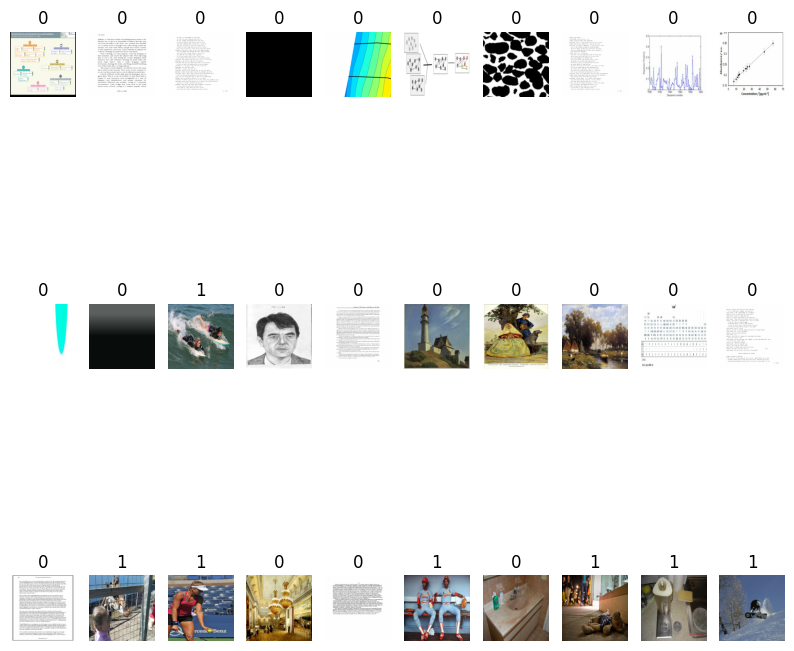

In [21]:
import random
n_images = 30
img_indexes = []

model = tf.keras.models.load_model('./final_model/12_4_2024_14h58.keras')

for n in range(n_images):
    img_indexes.append(random.randint(0, len(data)))

display_imgs = data.iloc[img_indexes].copy()

#create a loader
display_loader = ImageGenerator(display_imgs['pathname'].tolist(), display_imgs['label'].tolist(), len(display_imgs))
prediction = model.predict(display_loader)

plt.figure(figsize=(10, 10))
for images, labels in display_loader:
    for i in range(n_images):
        ax =  plt.subplot(3 ,10,i+1)
        plt.imshow(images[i]/255, cmap=plt.cm.binary)
        plt.title(np.argmax(prediction[i]))
        plt.axis("off")



# Conslusion
Nous avons donc notre modèle capable de classifier des images qui sont des photos des autres images, avec une accuracy approchant les 90%.

Pour améliorer ces résultats, nous pouvons augmenter les données en ajoutant du bruit ou changer la couleur en passant nos images en niveaux de gris par exemple, mais le résultat acquis reste convenable.